<h1> Laboratory work 1:  Text classification </h1>

Authors: Alexei Trutnev, Frolova Olga

## Exploratory data analysis

<h3> Dataset descriptions </h3>

The dataset <a href="https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data" target="_blank">  Twitter Sentiment Analysis </a> is used.

This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.


In [1]:
from pathlib import Path

from src.preprocessing import (load_dataset,
                               set_seed,
                               remove_stop_words,
                               remove_special_characters,
                               removing_digits,
                               convert_to_lowercase,
                               remove_extra_spaces,
                               normalization_text,
                               tokenize_word
                               )
from src.visualization import distribution_chart, sentiment_distribution_chart, generate_sentiment_wordclouds

set_seed()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alexgiving/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexgiving/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_path = Path('data/twitter_training.csv')

In [3]:
df = load_dataset(train_path)

In [4]:
df.head(10)

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


### Check the empty and irrelevant data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


Our dataset has empty `content` samples

In [6]:
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         73996 non-null  int64 
 1   entity     73996 non-null  object
 2   sentiment  73996 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


### Сheck duplication

In [8]:
print(f'Number of duplicates in the dataset: {df.duplicated().sum()}')

Number of duplicates in the dataset: 2340


In [9]:
# remove duplicates
df.drop_duplicates(inplace=True)

In [10]:
print(f'After remove duplicates, number of duplicates in the dataset: {df.duplicated().sum()}')

After remove duplicates, number of duplicates in the dataset: 0


### Distribution of sentiment

In [11]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts

sentiment
Negative      21698
Positive      19713
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_93930/3713511204.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  distribution_chart(sentiment_counts,'sentiment').show()


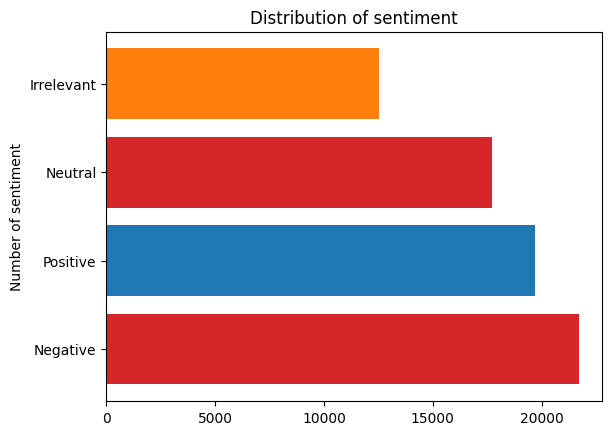

In [12]:
distribution_chart(sentiment_counts,'sentiment').show()

### Distribution of entity

In [13]:
entity = df['entity'].value_counts()

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_93930/3563687501.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  distribution_chart(entity, 'entity').show()


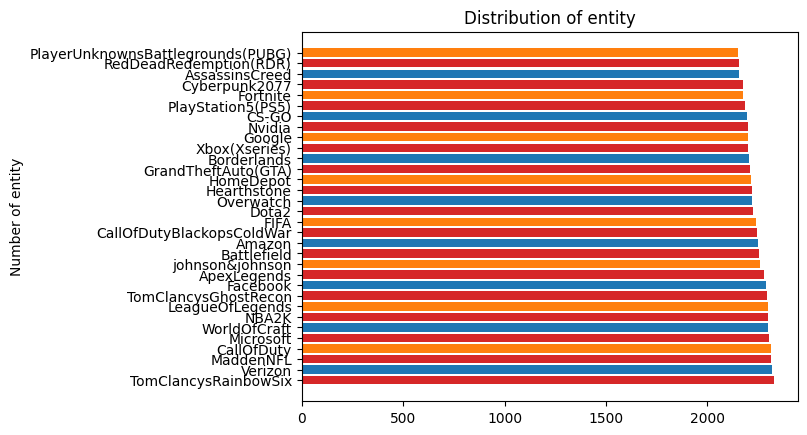

In [14]:
distribution_chart(entity, 'entity').show()

### Distribution of sentiment by entity

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_93930/621010469.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sentiment_distribution_chart(df, 'entity', 'sentiment').show()


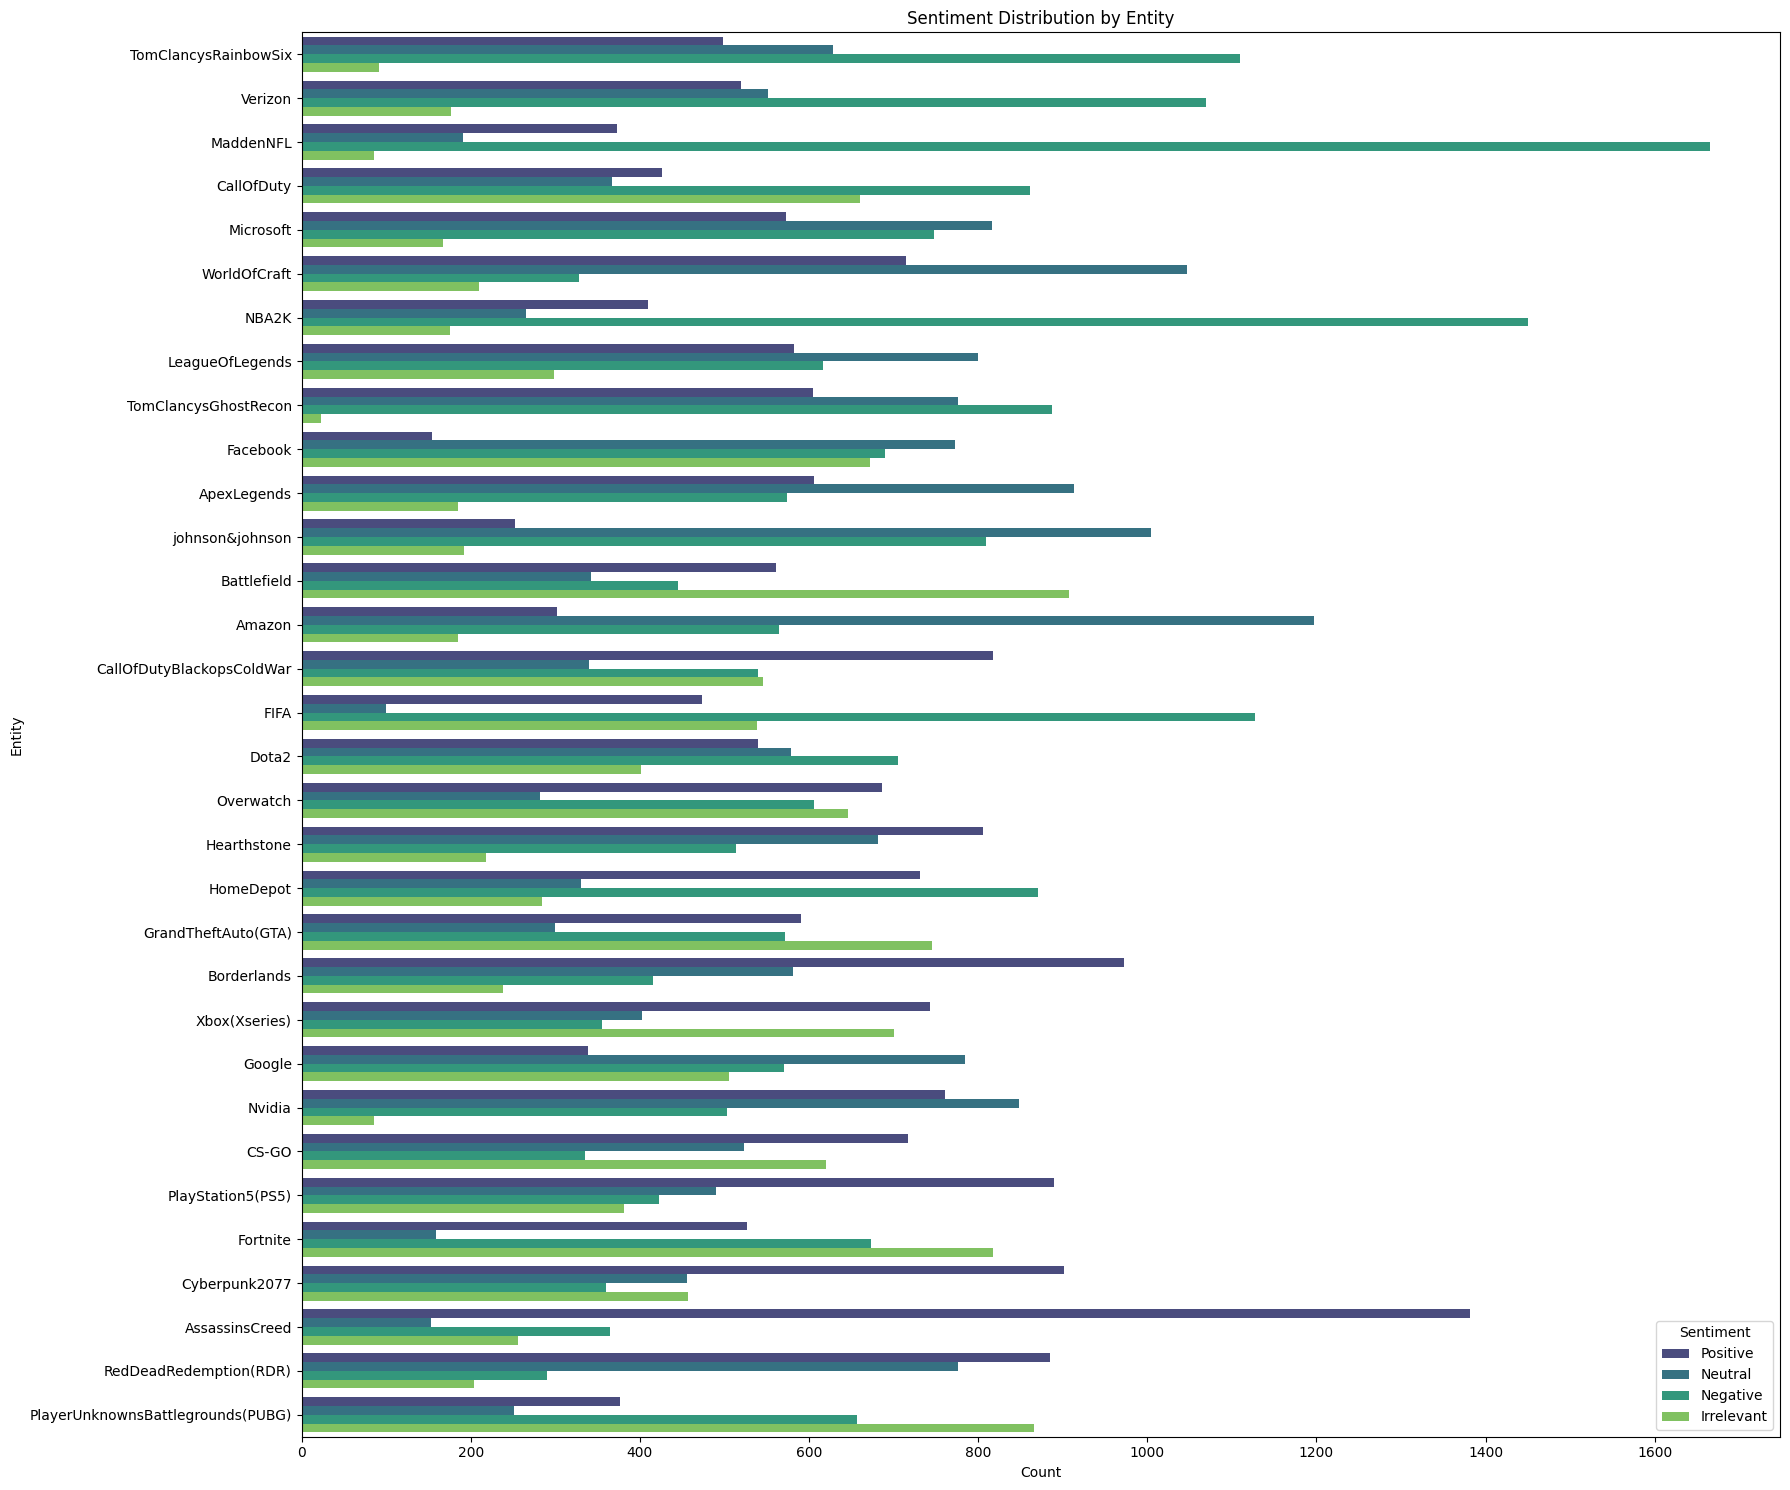

In [15]:
sentiment_distribution_chart(df, 'entity', 'sentiment').show()

### Word Cloud for each group sentiment 

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_93930/4027139701.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sentiments=['Positive', 'Negative', 'Neutral', 'Irrelevant']).show()


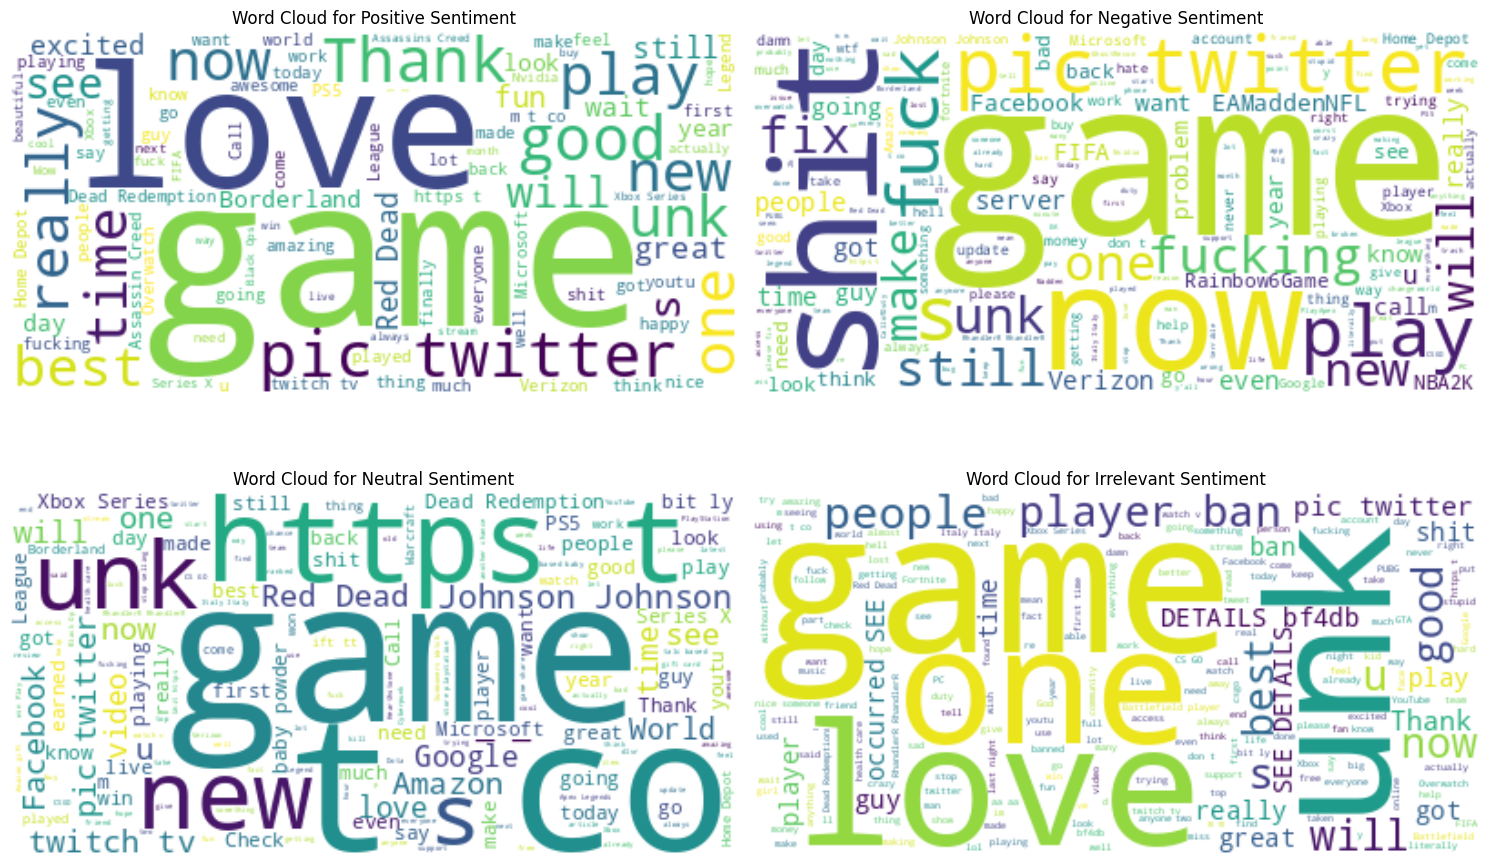

In [16]:
generate_sentiment_wordclouds(data=df,
                              sentiment_col='sentiment',
                              text_col='content',
                              sentiments=['Positive', 'Negative', 'Neutral', 'Irrelevant']).show()

### Data preprocessing

In [17]:
# remove stop words
df['content'] = df['content'].apply(remove_stop_words)
# remove special characters
df['content']= df['content'].apply(remove_special_characters)
# remove digits
df['content']= df['content'].apply(removing_digits)
# convert text to lowercase
df['content']= df['content'].apply(convert_to_lowercase)
# remove extra space
df['content']= df['content'].apply(remove_extra_spaces)

In [18]:
# Different variant normalization data: 'stemming', 'lemmatization', 'combo' (lemmatization + stemming)

df['content_lemma'] = df['content'].apply(lambda text: normalization_text('lemmatization', text))
df['content_stemming'] = df['content'].apply(lambda text: normalization_text('stemming', text))
df['content_combo'] = df['content'].apply(lambda text: normalization_text('combo', text))

### Embeddings

In [19]:
from sklearn.model_selection import train_test_split
from functools import partial

train_test_split = partial(train_test_split, test_size=0.2, random_state=40)

# We will have 4 variants for analysis

X_train, X_test, y_train, y_test = train_test_split(df['content'], df['sentiment'])
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(df['content_lemma'], df['sentiment'])
X_train_stemming, X_test_stemming, y_train_stemming, y_test_stemming = train_test_split(df['content_stemming'], df['sentiment'])
X_train_combo, X_test_combo, y_train_combo, y_test_combo = train_test_split(df['content_combo'], df['sentiment'])

## OneHotEncoder

In [20]:
from src.vectorizer import Vectorizer, VectorizerType

vectorizer = Vectorizer(VectorizerType.ONE_HOT)
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## word2vec

In [21]:
from src.vectorizer import Vectorizer, VectorizerType

vectorizer = Vectorizer(VectorizerType.W2V)
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## TF-IDF

In [22]:
from src.vectorizer import Vectorizer, VectorizerType

vectorizer = Vectorizer(VectorizerType.TF_IDF)
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## FAST-TEXT

In [23]:
from src.vectorizer import Vectorizer, VectorizerType

vectorizer = Vectorizer(VectorizerType.FAST_TEXT)
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)